In [1]:
# IMPORTING LIB
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

In [2]:
# Load csv file
df = pd.read_csv(r'c:\Users\Faaiz Anwar\Desktop\Amazon_Unlocked_Mobile.csv')
df.head()

Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews  Review Votes  
0       5  I feel so LUCKY to have found this used (phone...           1.0  
1       4  nice phone, nice up grade from my pantach revu...           0.0  
2       5                                       Very pleased           0.0  
3       4  It works good but it goes slow sometimes but i...           0.0  
4       4  Great phone to replace my lost phone. The only...           0.0

In [3]:
# DATA ANALYSIS
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Rating']==3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Rating']>3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Rating']<3]["Reviews"].count()/len(df)*100))

Summary statistics of numerical features : 
                Price         Rating   Review Votes
count  407907.000000  413840.000000  401544.000000
mean      226.867155       3.819578       1.507237
std       273.006259       1.548216       9.163853
min         1.730000       1.000000       0.000000
25%        79.990000       3.000000       0.000000
50%       144.710000       5.000000       0.000000
75%       269.990000       5.000000       1.000000
max      2598.000000       5.000000     645.000000

Total number of reviews:  413840

Total number of brands:  385

Total number of unique products:  4410

Percentage of reviews with neutral sentiment : 7.68%

Percentage of reviews with positive sentiment : 68.86%

Percentage of reviews with negative sentiment : 23.45%


Text(0, 0.5, 'Count')

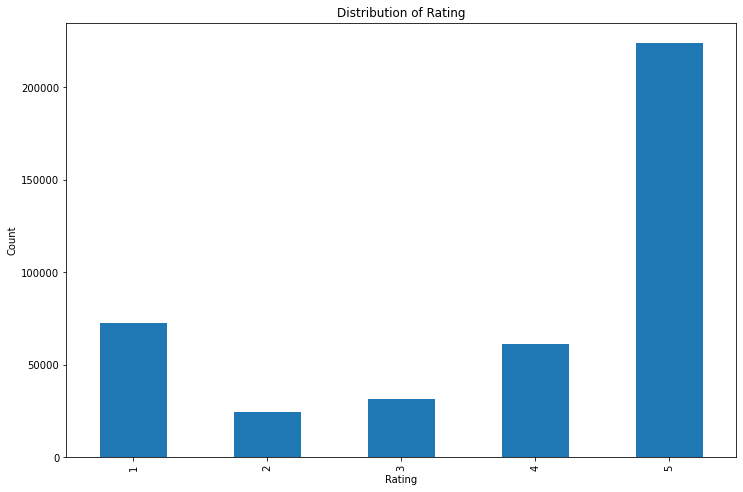

In [4]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

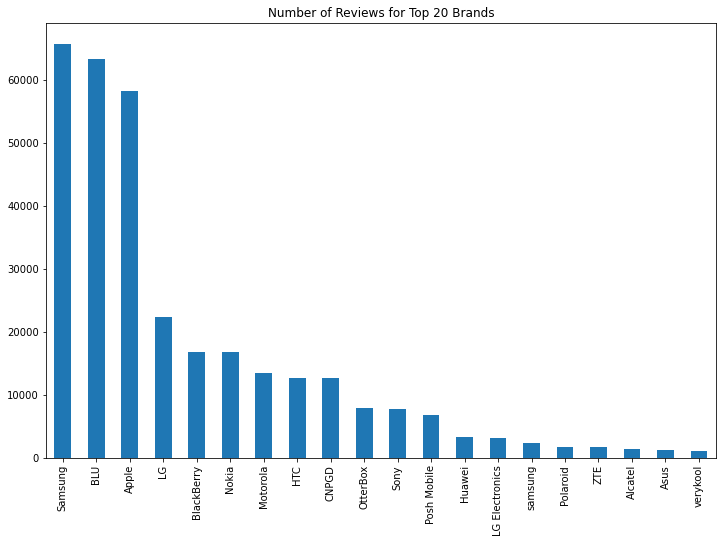

In [5]:
# Plot number of reviews for top 20 brands
brands = df["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

Text(0.5, 1.0, 'Number of Reviews for Top 50 Products')

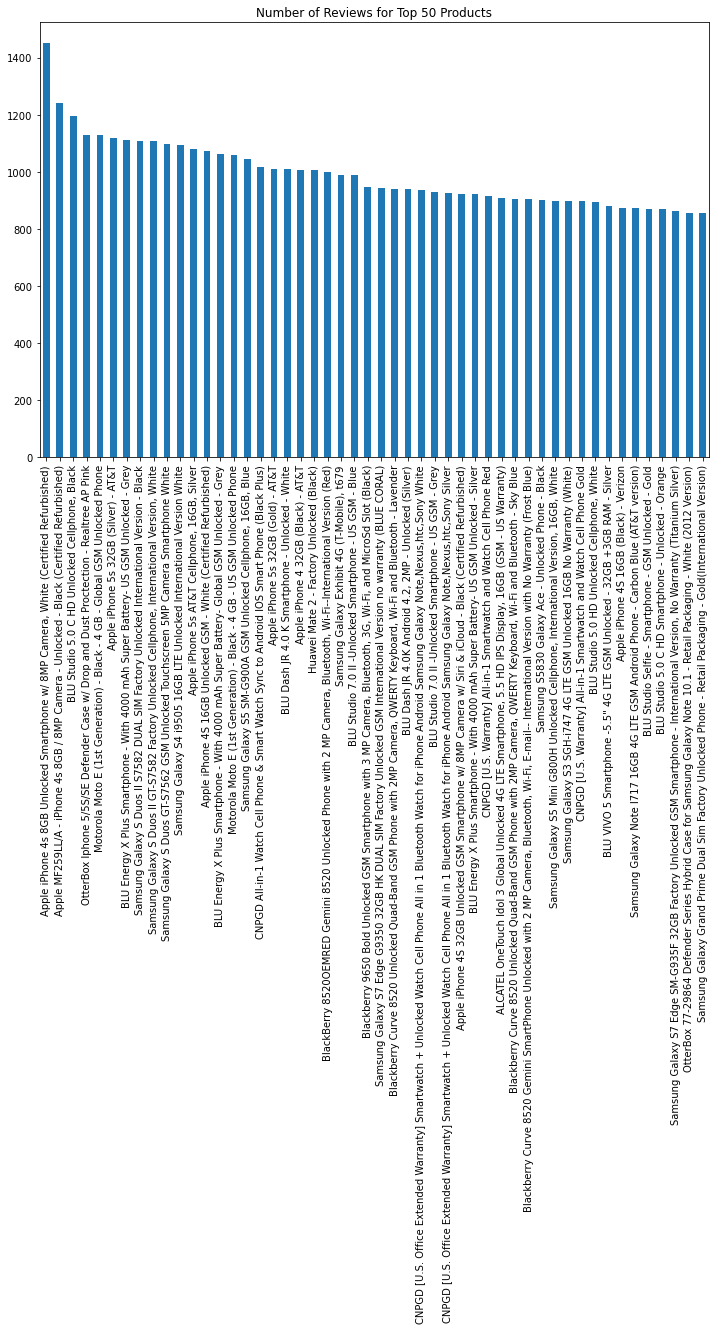

In [6]:
# Plot number of reviews for top 50 products
products = df["Product Name"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

Text(0, 0.5, 'Count')

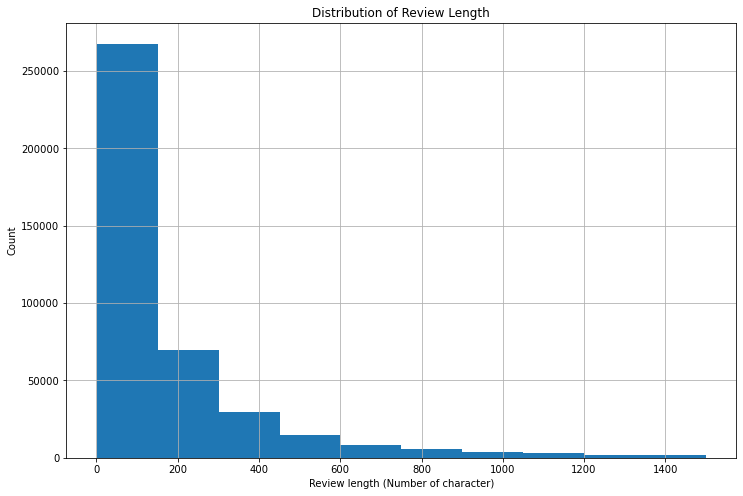

In [7]:
# Plot distribution of review length
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

In [8]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [9]:
df = df.sample(frac=0.1, random_state=0) 

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()

Product Name Brand Name    Price  \
134801  BLU Studio 5.0 C HD - Unlocked Cell Phones - R...        BLU  2000.00   
123493                         Blu LIFE 8 Unlocked (Pink)        BLU   199.98   
335592  Samsung Galaxy S Duos II S7582 DUAL SIM Factor...    Samsung   299.99   
246353  Motorola Droid 2 A955 Verizon Phone 5MP Cam, W...   Motorola    82.00   
273324  Nokia Lumia 920 32GB Unlocked GSM 4G LTE Windo...      Nokia   149.35   

        Rating                                            Reviews  \
134801       5  For the price I paid for this devices, its fan...   
123493       5  love love love it....good buy...recommend to a...   
335592       4                                               Good   
246353       1  Not good. Returned first phone and they sent m...   
273324       4  Met expectations! I'm very satisfied!Even arri...   

        Review Votes  Sentiment  
134801           0.0          1  
123493           0.0          1  
335592           0.0          1  
246353           0.0          0  
273324           1.0          1

In [10]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 27799 training examples and 3089 validation examples. 

Show a review in the training set : 
 good product and fast shipping. thank you.


In [11]:
#cleaning of data
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [12]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[14])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

C:\Users\Faaiz Anwar\Anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\Faaiz Anwar\Anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "https://www.amazon.com/dp/B00K15KRV6/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\Faaiz Anwar\Anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/B0193D539M?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an 

Show a cleaned review in the training set : 
 i got a used phone in a very bad condition very disappointed


In [13]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 5987 

Show some feature names : 
 ['00', 'changing', 'fall', 'letting', 'primarily', 'stars']


LogisticRegression()

In [14]:
# the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['not' 'return' 'disappointed' 'waste' 'horrible' 'worst' 'poor' 'slow'
 'stopped' 'doesn']

Top 10 features with largest coefficients : 
['great' 'love' 'excellent' 'perfect' 'good' 'easy' 'best' 'far' 'amazing'
 'awesome']


In [15]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAccuracy score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [16]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9310

Accuracy score : 0.8985

Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.83      0.86       778
           1       0.94      0.96      0.95      2311

    accuracy                           0.93      3089
   macro avg       0.92      0.90      0.91      3089
weighted avg       0.93      0.93      0.93      3089


Confusion Matrix : 
 [[ 648  130]
 [  83 2228]]
